In [1]:
# 코랩에 나눔고딕 폰트 설치

# https://m.blog.naver.com/happyyhj/222052692974
# https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=VXIb-7qeE_cm
# 이 방법으로는 실행되지 않음
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# https://teddylee777.github.io/colab/colab-korean/
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 0s (37.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and dir

- 플롯에 한글 폰트를 적용하기 위해 나눔고딕을 설치한 후, 런타임을 다시 시작해야 하므로 런타임 종료 코드를 실행한다.

In [ ]:
import os
os.kill(os.getpid(), 9) # 런타임 종료

In [1]:
# 일단 import
import glob
import pandas as pd

%matplotlib inline

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

import seaborn as sns

In [2]:
plt.rc('font', family='NanumBarunGothic')

In [3]:
# 데이터 준비
import numpy as np

data = np.random.randint(-200, 100, 50).cumsum()
data

array([ -111,  -169,  -329,  -435,  -380,  -316,  -354,  -484,  -427,
        -493,  -461,  -655,  -719,  -859,  -822, -1014,  -966,  -867,
        -957, -1031,  -933, -1115, -1153, -1198, -1136, -1249, -1289,
       -1283, -1443, -1568, -1647, -1615, -1633, -1666, -1772, -1842,
       -1825, -1962, -1963, -1962, -2025, -2095, -2008, -2047, -2240,
       -2394, -2383, -2522, -2682, -2779])

Text(0.5, 0, '시간(분)')

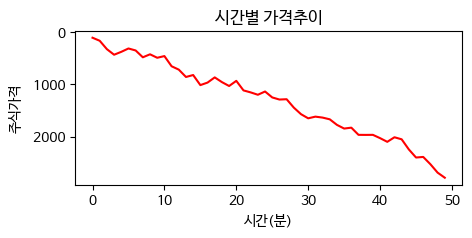

In [4]:
# 한글을 넣어놓고 그러보면 깨진다
plt.figure(figsize=(5,2))
plt.plot(range(50), data, 'r')
plt.title('시간별 가격추이')
plt.ylabel('주식가격')
plt.xlabel('시간(분)')

In [5]:
# 구글 드라이브 마운트하기.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 데이터 로드

## 서울시 상권분석서비스(상권영역) 로드 : 2021년 12월 기준
- 데이터 출처: [서울시 상권분석서비스(상권영역)](https://data.seoul.go.kr/dataList/OA-15560/S/1/datasetView.do)

In [6]:
df_sanggwon = pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/상권/서울시 상권분석서비스(상권영역).csv',
                        encoding='cp949')
display(df_sanggwon.shape, df_sanggwon.head())

(1671, 10)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,11545680,NaN
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,11545690,NaN
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,11710562,NaN


In [7]:
df_sanggwon['기준_년월_코드'].value_counts()

202112    1671
Name: 기준_년월_코드, dtype: int64

### x, y 좌표값으로 위,경도 데이터 뽑기

In [8]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 115.4 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import pyproj
import folium

In [10]:
# 좌표정보만 불러오기로 한다.

df_test = df_sanggwon[['엑스좌표_값', '와이좌표_값']]
display(df_test.dtypes, df_test.tail())

엑스좌표_값    int64
와이좌표_값    int64
dtype: object

,엑스좌표_값,와이좌표_값
1666,200974,451975
1667,199768,452273
1668,210191,446339
1669,205310,445727
1670,199503,448326


In [11]:
# 우선 좌표계를 변환해주는 함수를 다음과 같이 정의한다.

def project_array(coord, p1_type, p2_type):
    """
    좌표계 변환 함수
    - coord: x, y 좌표 정보가 담긴 NumPy Array
    - p1_type: 입력 좌표계 정보 ex) epsg:5179
    - p2_type: 출력 좌표계 정보 ex) epsg:4326
    """
    p1 = pyproj.Proj(init=p1_type)
    p2 = pyproj.Proj(init=p2_type)
    fx, fy = pyproj.transform(p1, p2, coord[:, 0], coord[:, 1])
    return np.dstack([fx, fy])[0]

In [12]:
# 좌표계 정보가 담긴 DataFrame 객체를 NumPy Array 객체로 만들고,
# 이 값을 위에서 정의한 함수에 다음과 같이 적용

# DataFrame -> NumPy Array 변환
coord = np.array(df_test)
coord

array([[191934, 438813],
       [206265, 459431],
       [192300, 439070],
       ...,
       [210191, 446339],
       [205310, 445727],
       [199503, 448326]])

In [13]:
# 좌표계 정보 설정
p1_type = "epsg:5181"
p2_type = "epsg:4326"

# project_array() 함수 실행
result = project_array(coord, p1_type, p2_type)
result

array([[126.90884426,  37.44868725],
       [127.07097812,  37.63446919],
       [126.91297783,  37.45100597],
       ...,
       [127.11527495,  37.51647607],
       [127.0600594 ,  37.51100291],
       [126.99437686,  37.53443511]])

In [14]:
# 이제 경도 위도 좌표계로 변환된 NumPy Array를 DataFrame에 추가
df_test['경도'] = result[:, 0]
df_test['위도'] = result[:, 1]

In [15]:
# 상권영역 데이터 기준으로 merge
df_sang_total = pd.merge(df_sanggwon, df_test, on=['엑스좌표_값', '와이좌표_값'])
display(df_sang_total.shape, df_sang_total.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,경도,위도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,11545710,NaN,126.908844,37.448687
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,11350611,NaN,127.070978,37.634469


### `행정동 코드` 컬럼값 변경

In [16]:
df_sang_total['행정동_코드'] = df_sang_total['행정동_코드'] % 1000
display(df_sang_total.shape, df_sang_total.head())

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,엑스좌표_값,와이좌표_값,시군구_코드,행정동_코드,형태정보,경도,위도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,191934,438813,11545,710,NaN,126.908844,37.448687
1,202112,A,골목상권,2110427,노원 을지대학교병원,206265,459431,11350,611,NaN,127.070978,37.634469
2,202112,A,골목상권,2110755,동일여자고등학교,192300,439070,11545,680,NaN,126.912978,37.451006
3,202112,A,골목상권,2110739,시흥3동 우편취급국,191289,438014,11545,690,NaN,126.901564,37.441482
4,202112,A,골목상권,2111017,송파나루역 3번,210222,445516,11710,562,NaN,127.115614,37.509060


In [17]:
df_sang_total.columns

Index(['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '엑스좌표_값',
       '와이좌표_값', '시군구_코드', '행정동_코드', '형태정보', '경도', '위도'],
      dtype='object')

In [18]:
# 활용할 컬럼만 추출
df_sang_final = df_sang_total[['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '시군구_코드', '행정동_코드', '위도', '경도']]
df_sang_final.head()

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시군구_코드,행정동_코드,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,11545,710,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,11350,611,37.634469,127.070978
2,202112,A,골목상권,2110755,동일여자고등학교,11545,680,37.451006,126.912978
3,202112,A,골목상권,2110739,시흥3동 우편취급국,11545,690,37.441482,126.901564
4,202112,A,골목상권,2111017,송파나루역 3번,11710,562,37.509060,127.115614


### 자치구 코드 정보 붙이기
- 데이터 출처: [행정구역 코드정보](https://data.seoul.go.kr/dataVisual/seoul/seoulLivingPopulation.do)

In [19]:
dong_code = pd.read_excel('/content/gdrive/MyDrive/ecothonCBB/data/상권/행정동코드_매핑정보_20200325.xlsx')

display(dong_code.shape, dong_code.head(2))

(425, 5)

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명
0,H_SDNG_CD,H_DNG_CD,DO_NM,CT_NM,H_DNG_NM
1,1101053,11110530,서울,종로구,사직동


In [20]:
## 자치구코드 컬럼 만들 경우
dong_code['자치구코드'] = dong_code['행자부행정동코드'].str.slice(start=0, stop=5)

## 행정동코드 컬럼 만들 경우
dong_code['행정동코드'] = dong_code['행자부행정동코드'].str.slice(start=-3)

dong_code.head()

,통계청행정동코드,행자부행정동코드,시도명,시군구명,행정동명,자치구코드,행정동코드
0,H_SDNG_CD,H_DNG_CD,DO_NM,CT_NM,H_DNG_NM,H_DNG,_CD
1,1101053,11110530,서울,종로구,사직동,11110,530
2,1101054,11110540,서울,종로구,삼청동,11110,540
3,1101055,11110550,서울,종로구,부암동,11110,550
4,1101056,11110560,서울,종로구,평창동,11110,560


In [21]:
# 첫 행 삭제 후, '자치구코드' 컬럼만 추출
dong_code = dong_code.drop([0], axis = 0)
dong_code_gu = dong_code[['시도명', '시군구명', '자치구코드', '행정동명', '행정동코드']]
dong_code_gu

,시도명,시군구명,자치구코드,행정동명,행정동코드
1,서울,종로구,11110,사직동,530
2,서울,종로구,11110,삼청동,540
3,서울,종로구,11110,부암동,550
4,서울,종로구,11110,평창동,560
5,서울,종로구,11110,무악동,570
...,...,...,...,...,...
420,서울,강동구,11740,둔촌1동,690
421,서울,강동구,11740,둔촌2동,700
422,서울,강동구,11740,암사1동,570
423,서울,강동구,11740,천호2동,610


In [22]:
# 중복행 제거
dong_code_gu = dong_code_gu.drop_duplicates(ignore_index=True)
dong_code_gu

,시도명,시군구명,자치구코드,행정동명,행정동코드
0,서울,종로구,11110,사직동,530
1,서울,종로구,11110,삼청동,540
2,서울,종로구,11110,부암동,550
3,서울,종로구,11110,평창동,560
4,서울,종로구,11110,무악동,570
...,...,...,...,...,...
419,서울,강동구,11740,둔촌1동,690
420,서울,강동구,11740,둔촌2동,700
421,서울,강동구,11740,암사1동,570
422,서울,강동구,11740,천호2동,610


In [23]:
# '자치구코드'와 '행정동코드' 모두 object 형에서 int 형으로 변환
dong_code_gu_dong = dong_code_gu.astype({'자치구코드':'int', '행정동코드':'int'})
print(dong_code_gu_dong.dtypes)

시도명      object
시군구명     object
자치구코드     int64
행정동명     object
행정동코드     int64
dtype: object


In [24]:
# 데이터셋 merge 하기
df_sang_code = pd.merge(df_sang_final, dong_code_gu_dong, how='left',
                        left_on=['시군구_코드','행정동_코드'],
                        right_on=['자치구코드', '행정동코드'])

# 데이터 확인
df_sang_code.head(2)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시군구_코드,행정동_코드,위도,경도,시도명,시군구명,자치구코드,행정동명,행정동코드
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,11545,710,37.448687,126.908844,서울,금천구,11545,시흥5동,710
1,202112,A,골목상권,2110427,노원 을지대학교병원,11350,611,37.634469,127.070978,서울,노원구,11350,하계1동,611


In [25]:
df_sang_fin = df_sang_code[['기준_년월_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '시도명', '시군구_코드',
       '시군구명', '행정동_코드', '행정동명','위도', '경도']]
display(df_sang_fin.shape, df_sang_fin.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,서울,11545,금천구,710,시흥5동,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,서울,11350,노원구,611,하계1동,37.634469,127.070978


### 서울시 상권분석서비스(상권-생활인구) 정보 붙이기 : 2017~2022년
- 데이터 출처: [서울시 상권분석서비스(상권-생활인구)](https://data.seoul.go.kr/dataList/OA-15568/S/1/datasetView.do)

In [26]:
df_population = pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울시_인구/서울시 상권분석서비스(상권-생활인구).csv',
                        encoding='cp949')
display(df_population.shape, df_population.head(2))

(40041, 532)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,55901,56757,8418,...,185,181,158,46,66,115,162,158,132,39
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,1757144,1875581,420460,...,6788,6949,8331,4315,7017,6913,6385,6565,7523,4113


In [27]:
df_population['기준 년코드'].value_counts(sort=False)

# 데이터가 2017~2022년까지 있다는 것을 확인!

2022    6674
2021    6672
2020    6674
2019    6676
2018    6673
2017    6672
Name: 기준 년코드, dtype: int64

#### 2022년 데이터만 가져오기

In [28]:
df_population_2022 = df_population[df_population['기준 년코드'] == 2022]
display(df_population_2022.shape, df_population_2022.head(2))

(6674, 532)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,55901,56757,8418,...,185,181,158,46,66,115,162,158,132,39
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,1757144,1875581,420460,...,6788,6949,8331,4315,7017,6913,6385,6565,7523,4113


In [29]:
# 사용할 컬럼만 추출
df_population_2022 = df_population_2022[['기준 년코드', '기준_분기_코드', '상권_구분_코드', ' 상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '총_생활인구_수']]
df_population_2022.head(2)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727


In [30]:
# 선택하여 열 이름 변경하기
df_population_2022 = df_population_2022.rename(columns={' 상권_구분_코드_명': '상권_구분_코드_명'})

## 상권영역(df_sang_fin)과 생활인구(df_population_2022) merge
- 상권영역(df_sang_fin): 2021년 12월 기준
- 생활인구(df_population_2022): 2022년 기준

In [31]:
# 상권영역(df_sang_fin): 2021년 12월 기준
display(df_sang_fin.shape, df_sang_fin.head(2))

(1671, 12)

,기준_년월_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,202112,A,골목상권,2110753,시흥동 은행나무사거리,서울,11545,금천구,710,시흥5동,37.448687,126.908844
1,202112,A,골목상권,2110427,노원 을지대학교병원,서울,11350,노원구,611,하계1동,37.634469,127.070978


In [32]:
# 생활인구(df_population_2022): 2022년 기준
display(df_population_2022.shape, df_population_2022.head(2))

(6674, 7)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727


### 생활인구(df_population_2022) 기준으로 상권영역(df_sang_fin) 과 merge : (6674, 14)

In [33]:
# 생활인구(df_population_2022) 기준으로 상권영역(df_sang_fin) 과 merge
df_pop_sang = pd.merge(df_population_2022, df_sang_fin,
                       how='left',
                       on=['상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명'])
display(df_pop_sang.shape, df_pop_sang.head(2))

(6674, 15)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,기준_년월_코드,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,202112,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,202112,서울,11710,송파구,566,오륜동,37.516476,127.115275


In [34]:
# 사용할 컬럼만 추출
df_pop_sang_fin = df_pop_sang[['기준 년코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명',
       '총_생활인구_수', '시도명', '시군구_코드', '시군구명', '행정동_코드', '행정동명', '위도', '경도']]
display(df_pop_sang_fin.shape, df_pop_sang_fin.head(2))

(6674, 14)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,서울,11710,송파구,566,오륜동,37.516476,127.115275


#### csv 파일로 저장

In [35]:
df_pop_sang_fin.to_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_위경도(수정).csv', index=False)

In [36]:
pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_위경도(수정).csv')

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,시도명,시군구_코드,시군구명,행정동_코드,행정동명,위도,경도
0,2022,4,U,관광특구,1001496,강남 마이스 관광특구,112658,서울,11680,강남구,580,삼성1동,37.511003,127.060059
1,2022,4,U,관광특구,1001495,잠실 관광특구,3632727,서울,11710,송파구,566,오륜동,37.516476,127.115275
2,2022,4,U,관광특구,1001494,종로?청계 관광특구,3957665,서울,11110,종로구,615,종로1.2.3.4가동,37.569998,126.997374
3,2022,4,U,관광특구,1001493,동대문패션타운 관광특구,3249964,서울,11140,중구,590,광희동,37.567312,127.011025
4,2022,4,U,관광특구,1001492,명동 남대문 북창동 다동 무교동 관광특구,4667755,서울,11140,중구,520,소공동,37.564149,126.981856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,2022,1,A,골목상권,2110005,세검정,173118,서울,11110,종로구,550,부암동,37.600950,126.962120
6670,2022,1,A,골목상권,2110004,대신고등학교,369100,서울,11110,종로구,570,무악동,37.573289,126.960550
6671,2022,1,A,골목상권,2110003,세검정초등학교,403155,서울,11110,종로구,550,부암동,37.604489,126.958801
6672,2022,1,A,골목상권,2110002,독립문역 1번,302828,서울,11110,종로구,570,무악동,37.575540,126.957209


## 2022년 각 분기별 데이터 수 확인

In [44]:
df_pop_sang_fin['기준_분기_코드'].value_counts()

4    1669
3    1669
2    1668
1    1668
Name: 기준_분기_코드, dtype: int64

### 시군구명별 총 생활인구 수 합계 확인: df_sang_group

In [45]:
df_sang_group = df_pop_sang_fin.groupby('시군구명')['총_생활인구_수'].sum().to_frame().reset_index()
df_sang_group

,시군구명,총_생활인구_수
0,강남구,337908221
1,강동구,277264660
2,강북구,175677212
3,강서구,237857874
4,관악구,279686042
5,광진구,229156656
6,구로구,160827953
7,금천구,100547986
8,노원구,128241927
9,도봉구,106216586


### 시군구명별 총 상가수 확인: df_sang_cnt

In [46]:
df_sang_cnt = df_pop_sang_fin['시군구명'].value_counts().to_frame().reset_index()

# 컬럼명을 변경하기
df_sang_cnt = df_sang_cnt.rename({'index':'시군구명','시군구명':'총_상가수'},axis='columns')

# 잘 바뀌었나 확인
df_sang_cnt

,시군구명,총_상가수
0,강남구,412
1,영등포구,392
2,중구,312
3,서초구,310
4,종로구,308
5,동대문구,308
6,마포구,308
7,성북구,304
8,관악구,296
9,송파구,280


### 시군구별 총 생활인구 수(df_sang_group)와 시군구별 총 상가 수(df_sang_cnt) merge

In [47]:
# 데이터셋 merge 하기
df_sang_m = pd.merge(df_sang_group, df_sang_cnt, on='시군구명')

# 데이터 확인
df_sang_m

,시군구명,총_생활인구_수,총_상가수
0,강남구,337908221,412
1,강동구,277264660,240
2,강북구,175677212,252
3,강서구,237857874,280
4,관악구,279686042,296
5,광진구,229156656,248
6,구로구,160827953,240
7,금천구,100547986,180
8,노원구,128241927,168
9,도봉구,106216586,172


## 시군구별 비율 컬럼 만들기

In [48]:
# 시군구별 인구수 비율을 구하여 컬럼 추가.
df_sang_m['인구수_비율']=df_sang_m['총_생활인구_수']/df_sang_m['총_생활인구_수'].sum()*100

# 시군구별 상가수 비율을 구하여 컬럼 추가.
df_sang_m['상가수_비율']=df_sang_m['총_상가수']/df_sang_m['총_상가수'].sum()*100

# 데이터 확인.
df_sang_m

,시군구명,총_생활인구_수,총_상가수,인구수_비율,상가수_비율
0,강남구,337908221,412,6.875060,6.173209
1,강동구,277264660,240,5.641210,3.596044
2,강북구,175677212,252,3.574318,3.775847
3,강서구,237857874,280,4.839441,4.195385
4,관악구,279686042,296,5.690475,4.435121
5,광진구,229156656,248,4.662407,3.715912
6,구로구,160827953,240,3.272196,3.596044
7,금천구,100547986,180,2.045743,2.697033
8,노원구,128241927,168,2.609202,2.517231
9,도봉구,106216586,172,2.161076,2.577165


### csv 파일로 저장

In [49]:
df_sang_m.to_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_비율.csv', index=False)

In [50]:
pd.read_csv('/content/gdrive/MyDrive/ecothonCBB/data/서울상권_인구_비율.csv')

,시군구명,총_생활인구_수,총_상가수,인구수_비율,상가수_비율
0,강남구,337908221,412,6.875060,6.173209
1,강동구,277264660,240,5.641210,3.596044
2,강북구,175677212,252,3.574318,3.775847
3,강서구,237857874,280,4.839441,4.195385
4,관악구,279686042,296,5.690475,4.435121
5,광진구,229156656,248,4.662407,3.715912
6,구로구,160827953,240,3.272196,3.596044
7,금천구,100547986,180,2.045743,2.697033
8,노원구,128241927,168,2.609202,2.517231
9,도봉구,106216586,172,2.161076,2.577165


### 인구수 비율: 막대그래프

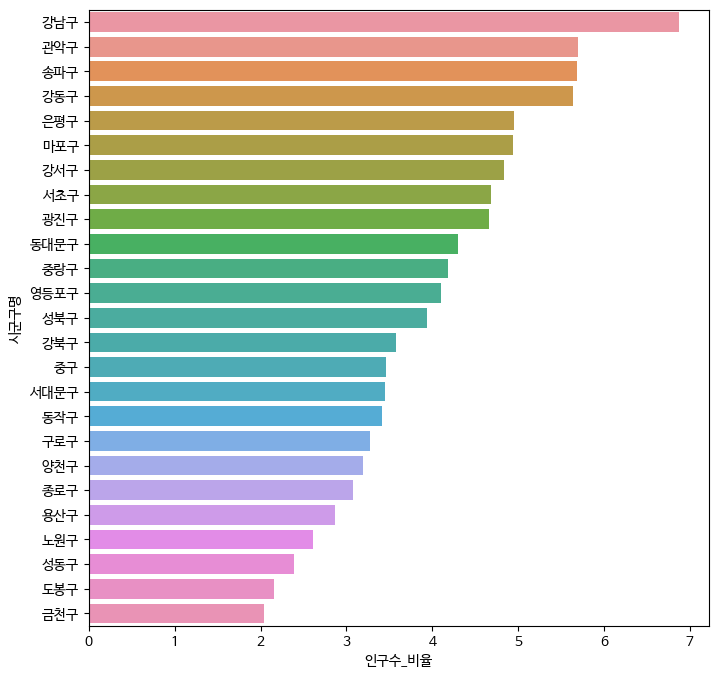

In [51]:
plt.figure(figsize=(8,8))  #size 조절
plt.xticks(rotation = 0)  #x축 조절

sns.barplot(
    data = df_sang_m.sort_values(by='인구수_비율', ascending=False),
    x = "인구수_비율",
    y = "시군구명"
    )
plt.show()

### 인구수 비율 및 상가수 비율 비교: 막대그래프

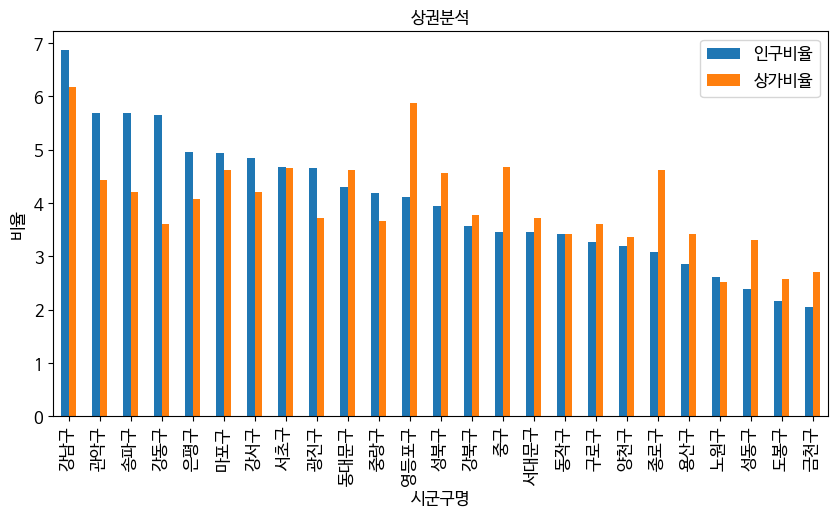

In [52]:
# 새로운 데이터셋에 시군구명, 인구수 비율, 상가수 비율 데이터만 넣기.
df_sang_m_ratio = df_sang_m[["시군구명","인구수_비율","상가수_비율"]]

# 시도명을 새로운 인덱스로 지정.
df_sang_m_ratio = df_sang_m_ratio.set_index("시군구명")

# 그래프 그리기.
ax = df_sang_m_ratio.sort_values(by='인구수_비율', ascending=False).plot(
    kind='bar', title='상권분석', figsize=(10, 5), legend=True, fontsize=12)
ax.set_xlabel('시군구명', fontsize=12)
ax.set_ylabel('비율', fontsize=12)
ax.legend(['인구비율', '상가비율'], fontsize=12)